# Traning for SY 1.9 & 2.0

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import time
import os
import datetime
import glob
import csv

import torchvision
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, random_split
from torchvision import transforms

import pandas as pd
import seaborn as sns

from numpy import genfromtxt

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## define functions

In [ ]:
def plotSpec(seyfert,n):
    if seyfert == 1.9:
        plt.plot(np.linspace(3800,7500,7500-3800+1), sy19_feature[n].tolist())
    if seyfert == 2:
        plt.plot(np.linspace(3800,7500,7500-3800+1), sy2_feature[n].tolist())
        
def plotData(data):
        plt.plot(np.linspace(3800,len(data)-1+3800,len(data)), data.tolist(),linewidth=1)
        
def plotFilters(filters):
    filters = filters.flatten()[1:-1].reshape(-1,2)
    for x in filters:
        plt.axvspan(x[0]+3800, x[1]+3800, alpha=0.5, facecolor='grey')
        
def sizeMap(inputSize):
    IN = inputSize
    C1 = (inputSize-50)+1
    S2 = int(C1/2)
    C3 = (S2-50)+1
    S4 = int(C3/2)
    C5 = (S4-50)+1
    S6 = int(C5/2)
    return IN, C1, S2, C3, S4, C5, S6 


def read_data(filename, delimiter=','):
    with open(filename, 'r') as my_file:
        reader = csv.reader(my_file, delimiter=delimiter)
        my_list = list(reader)[0]
        my_list= [float(i) for i in my_list]
        return my_list
    
    

## AGN Emission Lines (3000 - 8000 A)
https://ned.ipac.caltech.edu/level5/Netzer/Netzer2_1.html

```
CIII λ977
OVI λ1035
Lα
NV λ1240
OI λ1304
CII λ1336
SiIV,OIV] λ1400
NIV] λ1486
CIV λ1549 
HeII λ1640
OIII] λ1663
NIII] λ1750
CIII] λ1909
FeII λ(2200-2800)  
MgII λ2798
[NeV] λ3426
[OII] λ3727
[NeIII] λ3869
HeII λ4686
Hβ λ4861
[OIII] λ4959,5007
FeII λ(4500-5400) 
HeI λ5876
[FeVII] λ6087
[OI] λ6300
[FeX] λ6374
Hα λ6563
[NII] λ6583
[SII] λ6716,6731
CaII λ8498-8662
[SIII] λ9069,9532
```

The emission line spectrum of active galactic nuclei and the unifying scheme
https://link.springer.com/article/10.1007%2Fs001590000006

```
(Broad permmited lines)
HI, HeI λλ5876,6678,7065
He II λ4686
Fe II visible domain

(narrow line)
[Fe VII] λ6087
[Fe X] λ6375
[Fe XI] λ7892
```

add more balmer lines
```
Hγ λ4340
H-δ λ4102
```


FeII Lines, Table I in
https://arxiv.org/pdf/1004.2212.pdf


without FeII:

lines = [3869,4102,4340,4686,4861,4959,5007,5876,6087,6300,6374,6563,6583,6678,6716,6731,7065]


with Fe II:

lines = [3869,4102,4340,4473,4489,4491,4508,4515,4520,4523,4534,4542,4549,4556,4576,4583,4621,4629,4667,4686,4731,4861,4924,4959,4993,5007,5018,5146,5169,5198,5235,5265,5276,5284,5317,5326,5338,5363,5414,5425,5876,6087,6300,6374,6563,6583,6678,6716,6731,7065]

## read  data

In [ ]:
# The feature size is 1x(7500-3800+1), a pixel to one wavelenght
# merge data in previouly defined in different files
type1 = read_data('type1-z02-pixels-3800-7500-redshifted-lines-filtered-normalized.csv', delimiter=',')
sy20 = read_data('sy20-dr7-pixels-3800-7500-redshifted-lines-filtered-normalized-10000.csv', delimiter=',')
sy19 = read_data('sy19-dr7-pixels-3800-7500-redshifted-lines-filtered-normalized.csv', delimiter=',')

In [ ]:
## read sy19 with noise   
#sy19_noise = []
#for file in glob.glob('sy19-dr7-pixels-3800-7500-redshifted-lines-filtered-normalized-noise*csv'):
#    print('reading:', file)
#    file_feature = read_data(file, delimiter=',')
#    sy19_noise = np.concatenate((sy19_noise, file_feature), axis=0)

In [ ]:
## Full sample
## size of filtered spectrum 2079
##size of original spectrum 3701

type1_feature = torch.Tensor(np.concatenate((type1, sy19), axis=0)).view(-1,2021)
type2_feature = torch.Tensor(sy20).view(-1,2021)

In [ ]:
# classify 1.9 as 1, and 2 as 0. 
type1_label = torch.ones(type1_feature.size(0),dtype=torch.long)
type2_label = torch.zeros(type2_feature.size(0),dtype=torch.long)

# create indices
type1_indice = torch.linspace(0,len(type1_feature)-1,len(type1_feature)).int()
type2_indice = torch.linspace(0,len(type2_feature)-1,len(type2_feature)).int()

# taking same number of 1.9 and 2.0 seyfert galaxies
type1_dataset = TensorDataset(type1_indice,type1_feature,type1_label)
type2_dataset = TensorDataset(type2_indice[int(0.5*len(type1_feature)):int(1.5*len(type1_feature))],type2_feature[int(0.5*len(type1_feature)):int(1.5*len(type1_feature))],type2_label[int(0.5*len(type1_feature)):int(1.5*len(type1_feature))])

In [ ]:
# split to train and test datasets
train_ratio = 0.75

train_size = int(train_ratio * len(type1_dataset))
test_size = len(type1_dataset) - train_size

type1_dataset_train, type1_dataset_test = random_split(type1_dataset, [train_size, test_size])
type2_dataset_train, type2_dataset_test = random_split(type2_dataset, [train_size, test_size])

# merge the test dataset
dataset = ConcatDataset((type1_dataset_train,type2_dataset_train))

## CNN Network - One layer of Full CNN

### computing output size of image


- i = input
- o = output
- p = padding
- k = kernel_size
- s = stride
- d = dilation

o = [i + 2*p - k - (k-1)*(d-1)]/s + 1

In your case this gives o = [32 + 2 - 3 - 2*1]/1 +1 = [29] + 1 = 30.
Now, you could set all your parameters and “solve” the equation for p.
You will see, that p=2 will give you an output size of 32.

You could  with some tools like ezyang’s convolution visualizer 308 or calculate it with this formula:
https://ezyang.github.io/convolution-visualizer/index.html



###  Network Map

| Layer | Type | Maps | Kernel_size | Padding | Stride | Image_size | Activation | Comment |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
|  Out | Linear | - | - | - | - | 2 | - |  |
|  F7 | Linear | - | - | - | - | 100 | ReLU | 1000 -> 100  |
|  D6 | Dropout (0.5) | - | - | - | - | - | - | - |
|  C5 | Convolution | 1000 | 888 | 0 | 1 | 1 | ReLU |  |
|  S4 | Avg Pooling | 128 | 2 | 0 | 2 | 888 | - |  |
|  C3 | Convolution | 128 | 50 | 0 | 1 | 1777 | ReLU |  |
|  S2 | Avg Pooling | 64 | 2 | 0 | 2 | 1826 | - |  |
|  C1 | Convolution | 64 | 50 | 0 | 1 | 3652 | ReLU |  |
| In | Input | 1 | - | - |- | 3701 |- | |

In [ ]:
sizes = sizeMap(2021)

In [ ]:
sizes

In [ ]:
class simpleCNN(nn.Module):
    
    def __init__(self):
        super(simpleCNN, self).__init__()
        self.C1 = nn.Conv1d(1, 64, 50)
        self.S2 = nn.AvgPool1d(2, stride=2)
        self.C3 = nn.Conv1d(64, 128, 50)
        self.S4 = nn.AvgPool1d(2, stride=2)
        self.C5 = nn.Conv1d(128, 1000, sizes[4])
        self.D6 = nn.Dropout(0.5)
        self.F7 = nn.Linear(1000, 100)
        self.Out= nn.Linear(100, 2)
        
    def forward(self, x):
        x = F.relu(self.C1(x),inplace=True)
        x = self.S2(x)
        x = F.relu(self.C3(x),inplace=True)
        x = self.S4(x)
        x = F.relu(self.C5(x),inplace=True)
        x = self.D6(x)
        x = x.view(x.size(0),-1)
        x = F.relu(self.F7(x),inplace=True)
        x = self.Out(x)
        return x

In [ ]:
class simplerCNN(nn.Module):
    
    def __init__(self):
        super(simplerCNN, self).__init__()
        self.C1 = nn.Conv1d(1, 64, 50)
        self.B1 = nn.BatchNorm1d(64)
        self.S2 = nn.AvgPool1d(2, stride=2)
        self.C3 = nn.Conv1d(64, 128, 50)
        self.B3 = nn.BatchNorm1d(128)
        self.S4 = nn.AvgPool1d(2, stride=2)
        self.C5 = nn.Conv1d(128, 128, 50)
        self.B5 = nn.BatchNorm1d(128)
        self.S6 = nn.AvgPool1d(2, stride=2)
        self.D7 = nn.Dropout(0.5)
        self.F8 = nn.Linear(sizes[6]*128, 1000)
        self.F9 = nn.Linear(1000, 100)
        self.Out= nn.Linear(100, 2)
        
    def forward(self, x):
        x = F.relu(self.B1(self.C1(x)),inplace=True)
        x = self.S2(x)
        x = F.relu(self.B3(self.C3(x)),inplace=True)
        x = self.S4(x)
        x = F.relu(self.B5(self.C5(x)),inplace=True)
        x = self.S6(x)
        x = self.D7(x)
        x = x.view(x.size(0),-1)
        x = F.relu(self.F8(x),inplace=True)
        x = F.relu(self.F9(x),inplace=True)
        x = self.Out(x)
        return x

In [ ]:
net = simpleCNN()
print(net)

In [ ]:
## Test
x = torch.randn(5,1,sizes[0])
net(x)

### Check GPU availabel

In [ ]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    net.cuda(4)
    device = torch.device('cuda:4')
    print ('USE GPU')
else:
    device = torch.device('cpu')
    print ('USE CPU')

### define  accuracy 

In [ ]:
def accuracy(y_hat, y):
#    y_hat = torch.sign(y_hat)
    return (y_hat.argmax(dim=1) == y).float().mean().item()

def evaluate_accuracy(data_iter, net, device):
    acc = torch.tensor([0.0], device=device)
    for (index, img, label) in data_iter:
        img = img.view(-1,1,sizes[0])
        # if device is GPU，copy to GPU
        if use_gpu:
            index, img, label = index.to(device), img.to(device), label.to(device)
        acc += accuracy(net(img), label)
    return acc.item() / len(data_iter)

### TRAINING

In [ ]:
learning_rate = 0.01

loss = nn.CrossEntropyLoss() # include softmax and cross entropy
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9,0.999), eps=1e-8)
#optimizer = optim.SGD(net.parameters(), lr=learning_rate)

In [ ]:
num_epochs = 500

batch_size = 64
train_iter = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [ ]:
## laod previous traning results
#
#net.load_state_dict(torch.load('cuda3-GOOD.pt'))
#
#previous = pd.read_csv('./runs/acc-list-cuda3-2019-07-22-15-02-10-826651-GOOD.csv', header=0, comment='#')
#
#loss_list = list(previous['loss'])
#sy19_test_acc_list = list(previous['sy19_test_acc'])
#sy20_test_acc_list = list(previous['sy20_test_acc'])
#train_acc_list = list(previous['train_acc'])

In [ ]:
type1_test_acc_list = []
type2_test_acc_list = []
train_acc_list = []
loss_list = []

In [ ]:
for epoch in range(num_epochs):
    net.train() 
    start = time.time()
    train_l_sum = 0.
    train_acc_sum = 0.
    for (index, img, label) in train_iter:
        img = img.view(-1,1,sizes[0])
        if use_gpu:
            index, img, label = index.to(device), img.to(device), label.to(device)
        optimizer.zero_grad()
        predict = net(img)
        l = loss(predict, label.view(-1))
        l.backward()
        optimizer.step()
        train_l_sum += l.data.item()
        train_acc_sum += accuracy(predict, label.view(-1))
        #print(l)
    
    if ((epoch+1)%1 ==0):
        net.eval() 
        type1_test_iter = DataLoader(type1_dataset_test, batch_size=batch_size, shuffle=True, num_workers=4)
        type1_test_acc = evaluate_accuracy(type1_test_iter, net, device)
        type2_test_iter = DataLoader(type2_dataset_test, batch_size=batch_size, shuffle=True, num_workers=4)
        type2_test_acc = evaluate_accuracy(type2_test_iter, net, device)
        
        print('epoch %d, loss %.6f, train acc %.6f, type1 test acc  %.4f, type2 test acc  %.4f, '
                'time %.1f sec' % (epoch + 1, train_l_sum / len(train_iter),
                                    train_acc_sum / len(train_iter),
                                    type1_test_acc, type2_test_acc, time.time() - start))
        type1_test_acc_list.append(type1_test_acc)
        type2_test_acc_list.append(type2_test_acc)
        loss_list.append(train_l_sum / len(train_iter))
        train_acc_list.append(train_acc_sum / len(train_iter))
        if (train_l_sum / len(train_iter) < 0.1):
            learning_rate = 0.001
            optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        if (train_l_sum / len(train_iter) < 0.02):
            learning_rate = 0.0001
            optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)        

In [25]:
## save results
acc_lists = pd.DataFrame({'loss': loss_list, 'train_acc':train_acc_list, 'type1_test_acc': type1_test_acc_list, 'type2_test_acc': type2_test_acc_list})
acc_lists_filename = 'acc-list-cuda4-'+str(datetime.datetime.now()).replace(' ','-').replace(':','-').replace('.','-')+'.csv'
acc_lists.to_csv('./runs/'+acc_lists_filename)
print(acc_lists_filename)

model_filename = './runs/'+'model-cuda4-'+str(datetime.datetime.now()).replace(' ','-').replace(':','-').replace('.','-')+'.pt'
torch.save(net.state_dict(), 'model_filename')
print(model_filename)

acc-list-cuda4-2019-12-30-15-56-41-816450.csv
./runs/model-cuda4-2019-12-30-15-56-42-017695.pt


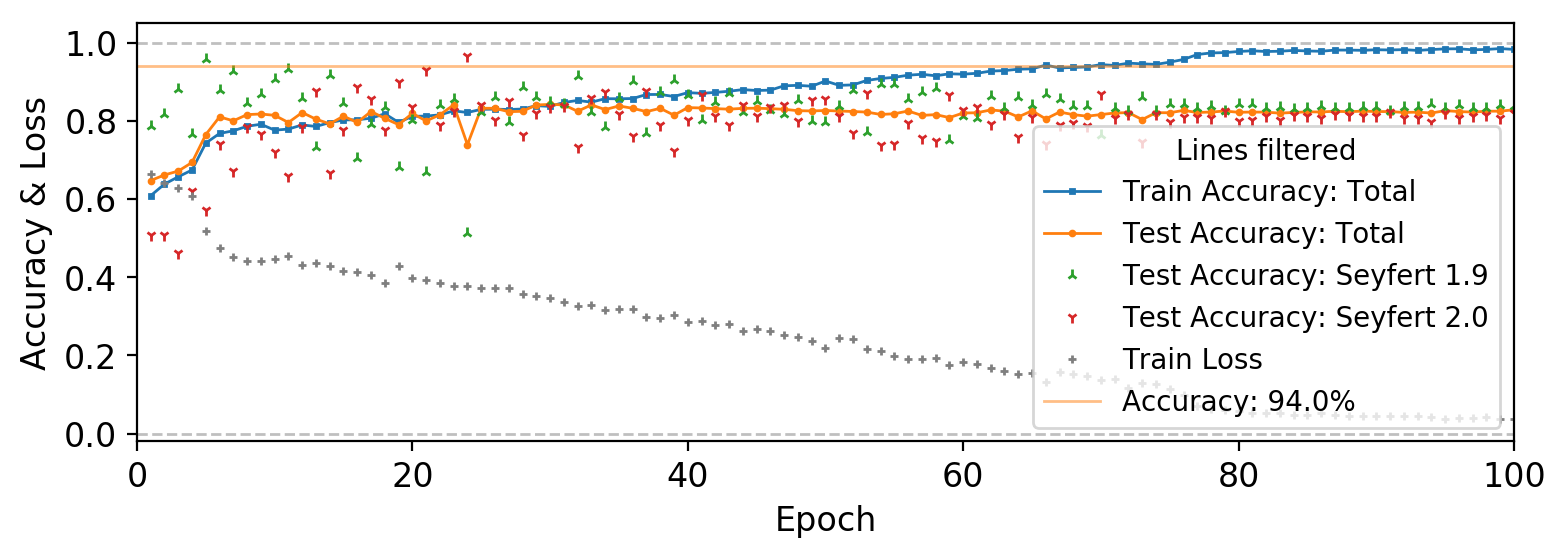

In [24]:
# save figure
fig = plt.figure(figsize=(8,3))
epoches = np.linspace(1,len(loss_list),len(loss_list))
plt.plot(epoches, train_acc_list, 's-', color='C0', linewidth=1, markersize=1.2,label='Train Accuracy: Total')
plt.plot(epoches, (np.array(type1_test_acc_list)+np.array(type2_test_acc_list))/2, '.-',  color='C1', markersize=3.5, linewidth=1,label='Test Accuracy: Total')
plt.plot(epoches, type1_test_acc_list, '2-', color='C2', linewidth=0,  markersize=4,label='Test Accuracy: Seyfert 1.9')
plt.plot(epoches, type2_test_acc_list, '1-', color='C3', linewidth=0,  markersize=4,label='Test Accuracy: Seyfert 2.0')
plt.plot(epoches, loss_list,'+-', color='C7', linewidth=0,  markersize=3,label='Train Loss')


plt.axhline(y=1.0,color='grey',linestyle='dashed',linewidth=1, alpha=0.5, label='')
#plt.axhline(y=0.84,color='C3',linestyle='solid',linewidth=3,  alpha=0.5,label='Accuracy: 83.0%')
plt.axhline(y=0.94,color='C1',linestyle='solid',linewidth=1,  alpha=0.5,label='Accuracy: 94.0%')
#plt.axhline(y=0.81,color='C2',linestyle='solid',linewidth=3,  alpha=0.5,label='Accuracy: 81.0%')
plt.axhline(y=0,color='grey',linestyle='dashed',linewidth=1,  alpha=0.5, label='')

leg = plt.legend(title='Lines filtered', fontsize=10)
leg._legend_box.align = "center"
plt.setp(leg.get_title(),fontsize=10)
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Accuracy & Loss',fontsize=12)

plt.xlim(0,100)
plt.ylim(-0.02,1.05)

figure_filename = './runs/'+'model-cuda4-'+str(datetime.datetime.now()).replace(' ','-').replace(':','-').replace('.','-')+'.pdf'
fig.tight_layout()
#plt.savefig(figure_filename, format='pdf')

In [ ]:
plt.semilogy(epoches, loss_list,label='loss')
plt.legend()